In [1]:
import logging
logging.getLogger('tensorflow').disabled = True
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # remove WARNING Messages
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
# parameter class fis parameters


class fis_parameters:
    def __init__(self, n_input: int = 3, n_memb: int = 3, batch_size: int = 16, n_epochs: int = 25, memb_func: str = 'gaussian', optimizer: str = 'sgd', loss: str = 'mse'):
        """
        Initializes parameters for a fuzzy inference system.

        Args:
            n_input (int): Number of regressors, representing the input dimensions.
            n_memb (int): Number of fuzzy memberships, determining the granularity of membership functions.
            batch_size (int): Size of batches to be used during training.
            n_epochs (int): Number of epochs, indicating the number of times the learning algorithm will work through the entire training dataset.
            memb_func (str): Type of membership function to be used, e.g., 'gaussian' or 'gbellmf'.
            optimizer (str): Optimization algorithm, such as 'sgd' (Stochastic Gradient Descent) or 'adam'.
            loss (str): Loss function to be minimized during training, e.g., 'mse' (Mean Squared Error) or 'mae' (Mean Absolute Error).
        """
        self.n_input = n_input
        self.n_memb = n_memb
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.memb_func = memb_func
        self.optimizer = optimizer
        self.loss = loss


# Main Class ANFIS
class ANFIS:
    def __init__(self, n_input: int, n_memb: int, batch_size: int = 16, memb_func: str = 'gaussian', name: str = 'MyAnfis'):
        """
        Initializes an Adaptive Neuro-Fuzzy Inference System (ANFIS) model.

        Args:
            n_input (int): Number of input features.
            n_memb (int): Number of fuzzy memberships.
            batch_size (int, optional): Size of batches for training. Defaults to 16.
            memb_func (str, optional): Type of membership function, e.g., 'gaussian'. Defaults to 'gaussian'.
            name (str, optional): Name of the ANFIS model. Defaults to 'MyAnfis'.
        """
        self.n = n_input
        self.m = n_memb
        self.batch_size = batch_size
        self.memb_func = memb_func
        input_ = keras.layers.Input(
            shape=(n_input,), name='inputLayer', batch_size=self.batch_size)
        L1 = FuzzyLayer(n_input, n_memb, memb_func, name='fuzzyLayer')(input_)
        L2 = RuleLayer(n_input, n_memb, name='ruleLayer')(L1)
        L3 = NormLayer(name='normLayer')(L2)
        L4 = DefuzzLayer(n_input, n_memb, name='defuzzLayer')(L3, input_)
        L5 = SummationLayer(name='sumLayer')(L4)
        self.model = keras.Model(inputs=[input_], outputs=[L5], name=name)
        self.update_weights()

    def __call__(self, X):
        """
        Makes predictions using the ANFIS model.

        Args:
            X (numpy.ndarray): Input data.

        Returns:
            numpy.ndarray: Predicted values.
        """
        return self.model.predict(X, batch_size=self.batch_size)

    def update_weights(self):
        """
        Updates the weights of the ANFIS model.

        This function retrieves and updates the premise and consequence parameters based on the membership function type.
        """
        # premise parameters (mu&sigma for gaussian // a/b/c for bell-shaped)
        if self.memb_func == 'gaussian':
            self.mus, self.sigmas = self.model.get_layer(
                'fuzzyLayer').get_weights()
        elif self.memb_func == 'gbellmf':
            self.a, self.b, self.c = self.model.get_layer(
                'fuzzyLayer').get_weights()
        # consequence parameters
        self.bias, self.weights = self.model.get_layer(
            'defuzzLayer').get_weights()

    def plotmfs(self, show_initial_weights=False):
        """
        Plots the membership functions of the ANFIS model.

        Args:
            show_initial_weights (bool, optional): Whether to show the initial weights. Defaults to False.
        """
        n_input = self.n
        n_memb = self.m

        if self.memb_func == 'gaussian':
            mus, sigmas = np.around(self.model.get_layer(
                'fuzzyLayer').get_weights(), 2)
            mus, sigmas = mus.reshape(
                (n_memb, n_input, 1)), sigmas.reshape(n_memb, n_input, 1)

            xn = np.linspace(np.min(mus) - 2 * np.max(abs(sigmas)),
                             np.max(mus) + 2 * np.max(abs(sigmas)), 100).reshape((1, 1, -1))
            xn = np.tile(xn, (n_memb, n_input, 1))

            # broadcast all curves in one array
            memb_curves = np.exp(-np.square((xn - mus)) / np.square(sigmas))

            if show_initial_weights:
                mus_init, sigmas_init = np.around(self.init_weights, 2)
                mus_init, sigmas_init = mus_init.reshape(
                    n_memb, n_input, 1), sigmas_init.reshape(n_memb, n_input, 1)
                init_curves = np.exp(-np.square((xn - mus_init)
                                                ) / np.square(sigmas_init))

        elif self.memb_func == 'gbellmf':
            a, b, c = np.around(self.model.get_layer(
                'fuzzyLayer').get_weights(), 2)
            a, b, c = a.reshape((n_memb, n_input, 1)), b.reshape(
                n_memb, n_input, 1), c.reshape(n_memb, n_input, 1)

            xn = np.linspace(np.min(c) - 2 * np.max(abs(a)),
                             np.max(c) + 2 * np.max(abs(a)), 100).reshape((1, 1, -1))
            xn = np.tile(xn, (n_memb, n_input, 1))

            # broadcast all curves in one array
            memb_curves = 1 / (1 + np.square((xn - c) / a)**b)

            if show_initial_weights:
                a_init, b_init, c_init = np.around(self.init_weights, 2)
                a_init, b_init, c_init = a_init.reshape((n_memb, n_input, 1)), b_init.reshape(
                    n_memb, n_input, 1), c_init.reshape(n_memb, n_input, 1)
                init_curves = 1 / \
                    (1 + np.square((xn - c_init) / a_init)**b_init)

        elif self.memb_func == 'sigmoid':
            gammas, c = np.around(self.model.get_layer(
                'fuzzyLayer').get_weights(), 2)
            gammas, c = gammas.reshape(
                (n_memb, n_input, 1)), c.reshape(n_memb, n_input, 1)

            xn = np.linspace(np.min(c) - 2 * np.max(abs(c)), np.max(c) + 2 * np.max(
                abs(c)), 100).reshape((1, 1, -1))  # TODO: change confidence bands
            xn = np.tile(xn, (n_memb, n_input, 1))

            # broadcast all curves in one array
            memb_curves = 1 / (1 + np.exp(-gammas * (xn - c)))

            if show_initial_weights:
                gammas_init, c_init = np.around(self.init_weights, 2)
                gammas_init, c_init = gammas_init.reshape(
                    n_memb, n_input, 1), c_init.reshape(n_memb, n_input, 1)
                init_curves = 1 / (1 + np.exp(-gammas_init * (xn - c_init)))

        fig, axs = plt.subplots(nrows=n_input, ncols=1, figsize=(8, self.n * 3))
        fig.suptitle('Membership functions', size=16)
        for n in range(self.n):
            axs[n].grid(True)
            axs[n].set_title(f'Input {n+1}')
            for m in range(self.m):
                axs[n].plot(xn[m, n, :], memb_curves[m, n, :])

        if show_initial_weights:  # plot initial membership curve
            for n in range(self.n):
                axs[n].set_prop_cycle(None)  # reset color cycle
                for m in range(self.m):
                    axs[n].plot(xn[m, n, :], init_curves[m, n, :],
                                '--', alpha=.5)
        plt.show()

    def fit(self, X, y, **kwargs):
        """
        Fits the ANFIS model to the training data.

        Args:
            X (numpy.ndarray): Input data.
            y (numpy.ndarray): Target data.
            **kwargs: Additional arguments for training.

        Returns:
            History: A History object containing training metrics.
        """
        # save initial weights in the anfis class
        self.init_weights = self.model.get_layer('fuzzyLayer').get_weights()

        # fit model & update weights in the anfis class
        history = self.model.fit(X, y, **kwargs)
        self.update_weights()

        # clear the graphs
        tf.keras.backend.clear_session()

        return history

    def get_memberships(self, Xs):
        """
        Computes the membership values for input data.

        Args:
            Xs (numpy.ndarray): Input data.

        Returns:
            numpy.ndarray: Membership values.
        """
        intermediate_layer_model = keras.Model(inputs=self.model.input,
                                               outputs=self.model.get_layer('normLayer').output)

        intermediate_L2_output = intermediate_layer_model.predict(Xs)

        return intermediate_L2_output


# Custom weight initializer
def equally_spaced_initializer(shape, minval=-1.5, maxval=1.5, dtype=tf.float32):
    """
    Custom weight initializer:
        euqlly spaced weights along an operating range of [minval, maxval].
    """
    linspace = tf.reshape(tf.linspace(minval, maxval, shape[0]),
                          (-1, 1))
    return tf.Variable(tf.tile(linspace, (1, shape[1])))


# Layer 1
class FuzzyLayer(keras.layers.Layer):
    def __init__(self, n_input, n_memb, memb_func='gaussian', **kwargs):
        """
        Initializes a Fuzzy Layer.

        Args:
            n_input (int): Number of input features.
            n_memb (int): Number of fuzzy memberships.
            memb_func (str, optional): Type of membership function. Defaults to 'gaussian'.
            **kwargs: Additional keyword arguments.
        """
        super(FuzzyLayer, self).__init__(**kwargs)
        self.n = n_input
        self.m = n_memb
        self.memb_func = memb_func

    def build(self, batch_input_shape):
        """
        Builds the Fuzzy Layer.

        Args:
            batch_input_shape (tuple): Batch input shape.
        """
        self.batch_size = batch_input_shape[0]

        if self.memb_func == 'gbellmf':
            self.a = self.add_weight(name='a',
                                     shape=(self.m, self.n),
                                     initializer=keras.initializers.RandomUniform(
                                         minval=.7, maxval=1.3, seed=1),
                                     #initializer = 'ones',
                                     trainable=True)
            self.b = self.add_weight(name='b',
                                     shape=(self.m, self.n),
                                     initializer=keras.initializers.RandomUniform(
                                         minval=.7, maxval=1.3, seed=1),
                                     #initializer = 'ones',
                                     trainable=True)
            self.c = self.add_weight(name='c',
                                     shape=(self.m, self.n),
                                     initializer=equally_spaced_initializer,
                                     #initializer = keras.initializers.RandomUniform(minval=-1.5, maxval=1.5, seed=1),
                                     #initializer = 'zeros',
                                     trainable=True)

        elif self.memb_func == 'gaussian':
            self.mu = self.add_weight(name='mu',
                                      shape=(self.m, self.n),
                                      initializer=equally_spaced_initializer,
                                      #initializer = keras.initializers.RandomUniform(minval=-1.5, maxval=1.5, seed=1),
                                      #initializer = 'zeros',
                                      trainable=True)
            self.sigma = self.add_weight(name='sigma',
                                         shape=(self.m, self.n),
                                         initializer=keras.initializers.RandomUniform(
                                             minval=.7, maxval=1.3, seed=1),
                                         #initializer = 'ones',
                                         trainable=True)

        elif self.memb_func == 'sigmoid':
            self.gamma = self.add_weight(name='gamma',
                                         shape=(self.m, self.n),
                                         initializer=equally_spaced_initializer,  # 'ones',
                                         trainable=True)

            self.c = self.add_weight(name='c',
                                     shape=(self.m, self.n),
                                     initializer=equally_spaced_initializer,  # 'ones',
                                     trainable=True)

        # Be sure to call this at the end
        super(FuzzyLayer, self).build(batch_input_shape)

    def call(self, x_inputs):
        """
        Computes the output of the Fuzzy Layer.

        Args:
            x_inputs (tensor): Input tensor.

        Returns:
            tensor: Output tensor.
        """
        if self.memb_func == 'gbellmf':
            L1_output = 1 / (1 +
                             tf.math.pow(
                                 tf.square(tf.subtract(
                                     tf.reshape(
                                         tf.tile(x_inputs, (1, self.m)), (-1, self.m, self.n)), self.c
                                 ) / self.a), self.b)
                             )
        elif self.memb_func == 'gaussian':
            L1_output = tf.exp(-1 *
                               tf.square(tf.subtract(
                                   tf.reshape(
                                       tf.tile(x_inputs, (1, self.m)), (-1, self.m, self.n)), self.mu
                               )) / tf.square(self.sigma))

        elif self.memb_func == 'sigmoid':
            L1_output = tf.math.divide(1,
                                       tf.math.exp(-self.gamma *
                                                   tf.subtract(
                                                       tf.reshape(
                                                           tf.tile(x_inputs, (1, self.m)), (-1, self.m, self.n)), self.c)
                                                   )
                                       )
        return L1_output


# Layer 2
class RuleLayer(keras.layers.Layer):
    def __init__(self, n_input, n_memb, **kwargs):
        """
        Initializes a Rule Layer.

        Args:
            n_input (int): Number of input features.
            n_memb (int): Number of fuzzy memberships.
            **kwargs: Additional keyword arguments.
        """
        super(RuleLayer, self).__init__(**kwargs)
        self.n = n_input
        self.m = n_memb
        self.batch_size = None

    def build(self, batch_input_shape):
        """
        Builds the Rule Layer.

        Args:
            batch_input_shape (tuple): Batch input shape.
        """
        self.batch_size = batch_input_shape[0]
        # self.batch_size = tf.shape(batch_input_shape)[0]
        # Be sure to call this at the end
        super(RuleLayer, self).build(batch_input_shape)

    def call(self, input_):
        """
        Computes the output of the Rule Layer.

        Args:
            input_ (tensor): Input tensor.

        Returns:
            tensor: Output tensor.
        """
        if self.n == 2:
            L2_output = tf.reshape(input_[:, :, 0], [self.batch_size, -1, 1]) * \
                tf.reshape(input_[:, :, 1], [self.batch_size, 1, -1])
        elif self.n == 3:
            L2_output = tf.reshape(input_[:, :, 0], [self.batch_size, -1, 1, 1]) * \
                tf.reshape(input_[:, :, 1], [self.batch_size, 1, -1, 1]) * \
                tf.reshape(input_[:, :, 2], [self.batch_size, 1, 1, -1])
        elif self.n == 4:
            L2_output = tf.reshape(input_[:, :, 0], [self.batch_size, -1, 1, 1, 1]) * \
                tf.reshape(input_[:, :, 1], [self.batch_size, 1, -1, 1, 1]) * \
                tf.reshape(input_[:, :, 2], [self.batch_size, 1, 1, -1, 1]) * \
                tf.reshape(input_[:, :, 3], [self.batch_size, 1, 1, 1, -1])
        elif self.n == 5:
            L2_output = tf.reshape(input_[:, :, 0], [self.batch_size, -1, 1, 1, 1, 1]) * \
                tf.reshape(input_[:, :, 1], [self.batch_size, 1, -1, 1, 1, 1]) * \
                tf.reshape(input_[:, :, 2], [self.batch_size, 1, 1, -1, 1, 1]) * \
                tf.reshape(input_[:, :, 3], [self.batch_size, 1, 1, 1, -1, 1]) * \
                tf.reshape(input_[:, :, 4], [self.batch_size, 1, 1, 1, 1, -1])
        elif self.n == 6:
            L2_output = tf.reshape(input_[:, :, 0], [self.batch_size, -1, 1, 1, 1, 1, 1]) * \
                tf.reshape(input_[:, :, 1], [self.batch_size, 1, -1, 1, 1, 1, 1]) * \
                tf.reshape(input_[:, :, 2], [self.batch_size, 1, 1, -1, 1, 1, 1]) * \
                tf.reshape(input_[:, :, 3], [self.batch_size, 1, 1, 1, -1, 1, 1]) * \
                tf.reshape(input_[:, :, 4], [self.batch_size, 1, 1, 1, 1, -1, 1]) * \
                tf.reshape(input_[:, :, 5], [
                           self.batch_size, 1, 1, 1, 1, 1, -1])
        else:
            raise ValueError(
                f'This ANFIS implementation works with 2 to 6 inputs.')

        return tf.reshape(L2_output, [self.batch_size, -1])


# Layer 3
class NormLayer(keras.layers.Layer):
    def __init__(self, **kwargs):
        """
        Initializes a Normalization Layer.

        Args:
            **kwargs: Additional keyword arguments.
        """
        super().__init__(**kwargs)

    def call(self, w):
        """
        Computes the output of the Normalization Layer.

        Args:
            w (tensor): Input tensor.

        Returns:
            tensor: Output tensor.
        """
        w_sum = tf.reshape(tf.reduce_sum(w, axis=1), (-1, 1))
        w_norm = w / w_sum
        return w_norm


# Layer 4
class DefuzzLayer(keras.layers.Layer):
    def __init__(self, n_input, n_memb, **kwargs):
        """
        Initializes a Defuzzification Layer.

        Args:
            n_input (int): Number of input features.
            n_memb (int): Number of fuzzy memberships.
            **kwargs: Additional keyword arguments.
        """
        super().__init__(**kwargs)
        self.n = n_input
        self.m = n_memb

        self.CP_bias = self.add_weight(name='Consequence_bias',
                                       shape=(1, self.m ** self.n),
                                       initializer=keras.initializers.RandomUniform(
                                           minval=-2, maxval=2),
                                       # initializer = 'ones',
                                       trainable=True)
        self.CP_weight = self.add_weight(name='Consequence_weight',
                                         shape=(self.n, self.m ** self.n),
                                         initializer=keras.initializers.RandomUniform(
                                             minval=-2, maxval=2),
                                         # initializer = 'ones',
                                         trainable=True)

    def call(self, w_norm, input_):
        """
        Computes the output of the Defuzzification Layer.

        Args:
            w_norm (tensor): Normalized weights tensor.
            input_ (tensor): Input tensor.

        Returns:
            tensor: Output tensor.
        """
        L4_L2_output = tf.multiply(w_norm,
                                   tf.matmul(input_, self.CP_weight) + self.CP_bias)
        return L4_L2_output  # Defuzzyfied Layer


# Layer 5
class SummationLayer(keras.layers.Layer):
    def __init__(self, **kwargs):
        """
        Initializes a Summation Layer.

        Args:
            **kwargs: Additional keyword arguments.
        """
        super().__init__(**kwargs)

    def build(self, batch_input_shape):
        """
        Builds the Summation Layer.

        Args:
            batch_input_shape (tuple): Batch input shape.
        """
        self.batch_size = batch_input_shape[0]
        # Be sure to call this at the end
        super(SummationLayer, self).build(batch_input_shape)

    def call(self, input_):
        """
        Computes the output of the Summation Layer.

        Args:
            input_ (tensor): Input tensor.

        Returns:
            tensor: Output tensor.
        """
        L5_L2_output = tf.reduce_sum(input_, axis=1)
        L5_L2_output = tf.reshape(L5_L2_output, (-1, 1))
        return L5_L2_output


In [2]:
import pandas as pd
import numpy as np
import sys
sys.maxsize

from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf

In [3]:
df = pd.read_csv('power_data.csv') 
df.shape

(308, 7)

In [4]:
df.head()

,POTENCIA(K-2),POTENCIA(K-1),POTENCIA,ENERGIA(K-2),ENERGIA(K-1),ENERGIA,POTENCIA(K+1)
0,16.299999,16.700001,16.600000,265.675000,268.475001,269.250000,16.700001
1,19.299999,18.400000,19.700001,331.049999,320.425000,330.775003,19.600000
2,19.200001,20.600000,19.887368,329.025002,352.949997,341.237494,19.900000
3,18.400000,19.100000,18.200001,314.174999,315.775000,319.162500,20.000000
4,18.200001,18.299999,18.400000,307.825000,297.724998,306.674999,18.600000


In [5]:
df.describe()

,POTENCIA(K-2),POTENCIA(K-1),POTENCIA,ENERGIA(K-2),ENERGIA(K-1),ENERGIA,POTENCIA(K+1)
count,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000
mean,19.687520,19.707649,19.723234,334.197699,334.533372,334.814347,19.747585
std,2.620544,2.605104,2.595992,47.847303,47.604325,47.454979,2.596130
min,12.900000,12.900000,12.900000,216.400001,216.400001,216.400001,12.900000
25%,18.200001,18.200001,18.200001,306.387499,307.223437,307.720312,18.200001
50%,19.843684,19.887368,19.893684,340.437500,340.631250,341.031247,19.900000
75%,21.824999,21.824999,21.824999,374.718751,374.718751,374.718751,21.900000
max,24.100000,24.100000,24.100000,412.000001,412.000001,412.000001,24.100000


In [6]:
scaler=MinMaxScaler()
df2=scaler.fit_transform(df)
df2

array([[0.30357137, 0.33928579, 0.33035719, ..., 0.26623211, 0.27019427,
        0.33928579],
       [0.5714285 , 0.4910714 , 0.60714292, ..., 0.53182515, 0.58473927,
        0.59821431],
       [0.56250006, 0.68750002, 0.62387213, ..., 0.69810836, 0.63822849,
        0.62499996],
       ...,
       [0.37500004, 0.39285708, 0.40178569, ..., 0.35876789, 0.34253579,
        0.5       ],
       [0.43749994, 0.52678564, 0.38392865, ..., 0.45558537, 0.35161043,
        0.41071429],
       [0.58928571, 0.5714285 , 0.5714285 , ..., 0.56071064, 0.58614519,
        0.4910714 ]])

In [7]:
X=df2[:,0:6]
Y=df2[:,-1]

display(X)
display(Y)

array([[0.30357137, 0.33928579, 0.33035719, 0.25191717, 0.26623211,
        0.27019427],
       [0.5714285 , 0.4910714 , 0.60714292, 0.58614519, 0.53182515,
        0.58473927],
       [0.56250006, 0.68750002, 0.62387213, 0.57579244, 0.69810836,
        0.63822849],
       ...,
       [0.37500004, 0.39285708, 0.40178569, 0.34982106, 0.35876789,
        0.34253579],
       [0.43749994, 0.52678564, 0.38392865, 0.38586401, 0.45558537,
        0.35161043],
       [0.58928571, 0.5714285 , 0.5714285 , 0.56786809, 0.56071064,
        0.58614519]])

array([0.33928579, 0.59821431, 0.62499996, 0.63392856, 0.5089286 ,
       0.93749994, 0.83928562, 0.5       , 0.5       , 0.65178577,
       0.59821431, 0.66071421, 0.07142858, 0.62499996, 0.52678564,
       0.01785721, 0.97321419, 0.70535706, 0.47321436, 0.5       ,
       0.46428575, 0.81249998, 0.67857142, 0.93749994, 0.74999991,
       0.97321419, 0.87500004, 0.46428575, 0.37500004, 0.87500004,
       0.22133463, 0.89285708, 0.32142858, 0.4910714 , 0.44901318,
       0.40178569, 0.97321419, 0.73214288, 0.5089286 , 0.64285717,
       0.21428575, 0.80357137, 0.33928579, 0.78571433, 0.54464285,
       0.70535706, 0.41071429, 0.5803571 , 0.4910714 , 0.35714283,
       0.25      , 0.31249998, 0.58928571, 0.5714285 , 0.75892852,
       0.5714285 , 0.60714292, 0.25      , 0.27678573, 0.2589286 ,
       0.79464277, 0.74999991, 0.66964281, 0.89285708, 0.59821431,
       0.1696429 , 0.5089286 , 0.9196429 , 0.5714285 , 0.68750002,
       0.15178577, 0.79464277, 0.75892852, 0.61607135, 0.58928

In [8]:
print(Y.shape)
print(X.shape)

(308,)
(308, 6)


In [9]:
param = fis_parameters(
            n_input = 6,                # no. of Regressors
            n_memb = 3,                 # no. of fuzzy memberships
            batch_size = 1,            # 16 / 32 / 64 / ...
            memb_func = 'gaussian',      # 'gaussian' / 'gbellmf' / 'sigmoid'
            optimizer = 'adam',          # sgd / adam / ...
            loss = 'mse',               # mse / mae / huber_loss / mean_absolute_percentage_error / ...
            n_epochs = 100               # 10 / 25 / 50 / 100 / ...
            )

In [10]:
histories=[]
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [11]:
# inicialize the model
fis = ANFIS(n_input = param.n_input,
                        n_memb = param.n_memb,
                        batch_size = param.batch_size,
                        memb_func = param.memb_func,
                        name = 'myanfis'
                        )

In [12]:
# compile model
fis.model.compile(optimizer=param.optimizer,
                      loss=param.loss
                      ,metrics=['mae', 'mse']  # ['mae', 'mse']
                      )

In [13]:
# fit model
history = fis.fit(X_train, y_train,
                      epochs=param.n_epochs,
                      batch_size=param.batch_size,
                      validation_data = (X_test, y_test),
                       #callbacks = [tensorboard_callback]  # for tensorboard
                      )
histories.append(history)

Epoch 1/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0304 - mae: 0.1353 - mse: 0.0304 - val_loss: 0.0119 - val_mae: 0.0842 - val_mse: 0.0119
Epoch 2/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step - loss: 0.0098 - mae: 0.0757 - mse: 0.0098 - val_loss: 0.0095 - val_mae: 0.0770 - val_mse: 0.0095
Epoch 3/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step - loss: 0.0068 - mae: 0.0615 - mse: 0.0068 - val_loss: 0.0077 - val_mae: 0.0711 - val_mse: 0.0077
Epoch 4/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - loss: 0.0084 - mae: 0.0665 - mse: 0.0084 - val_loss: 0.0071 - val_mae: 0.0672 - val_mse: 0.0071
Epoch 5/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step - loss: 0.0085 - mae: 0.0654 - mse: 0.0085 - val_loss: 0.0071 - val_mae: 0.0665 - val_mse: 0.0071
Epoch 6/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - loss: 0.0058 - mae: 0.0555 - mse: 0.0058 - val_loss: 0.0068 - val_mae: 0.0677 - val_mse: 0.0068
Epoch 7/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - loss: 0.0065 - mae: 0.0580 

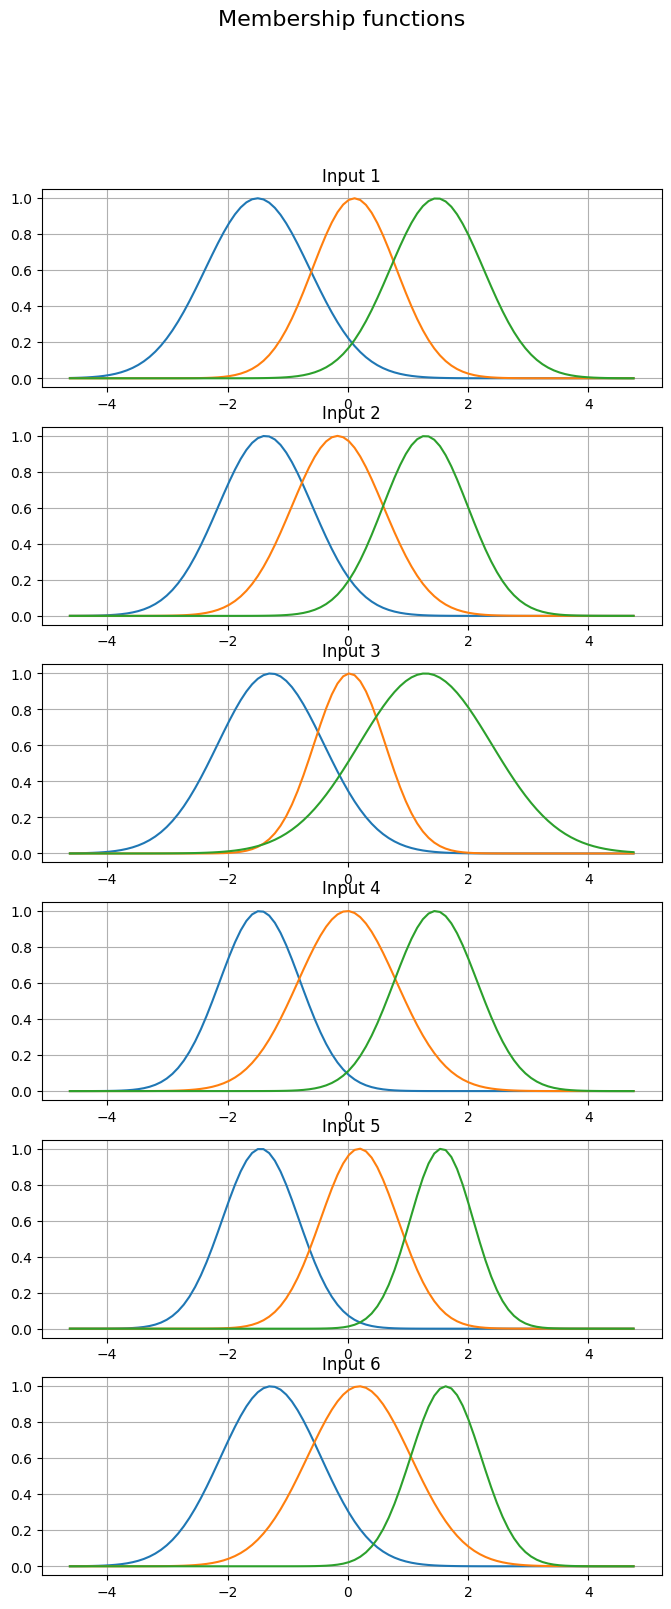

In [14]:
fis.plotmfs()

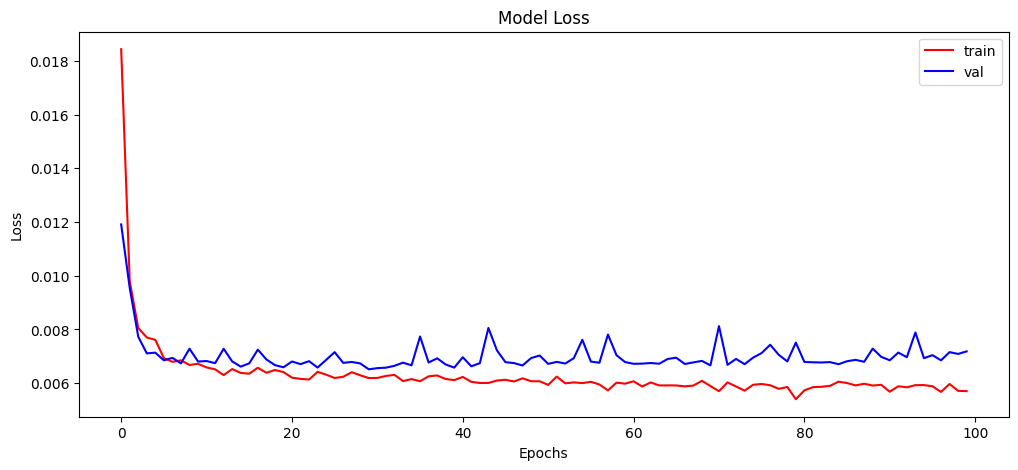

In [15]:
#Plot the loss history
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], color='r')
plt.plot(history.history['val_loss'], color='b')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

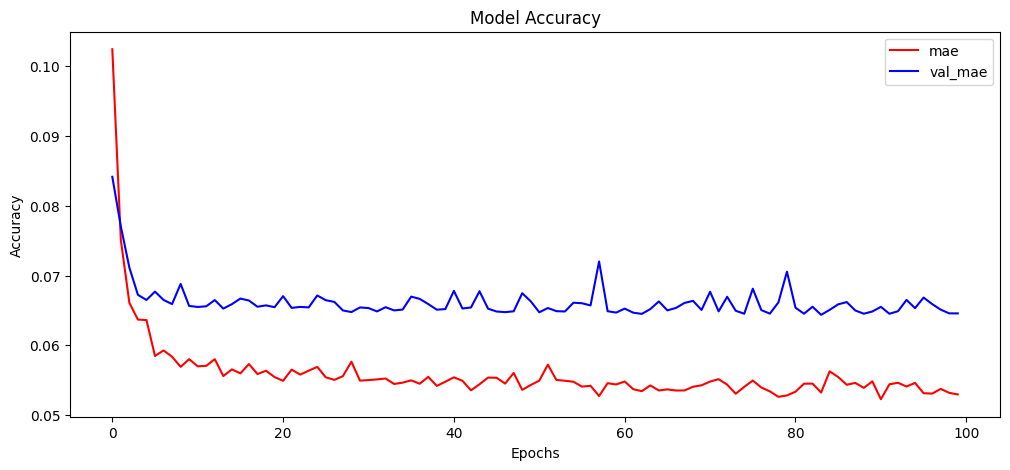

In [16]:
#Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['mae'], color='r')
plt.plot(history.history['val_mae'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['mae', 'val_mae'])
plt.show()

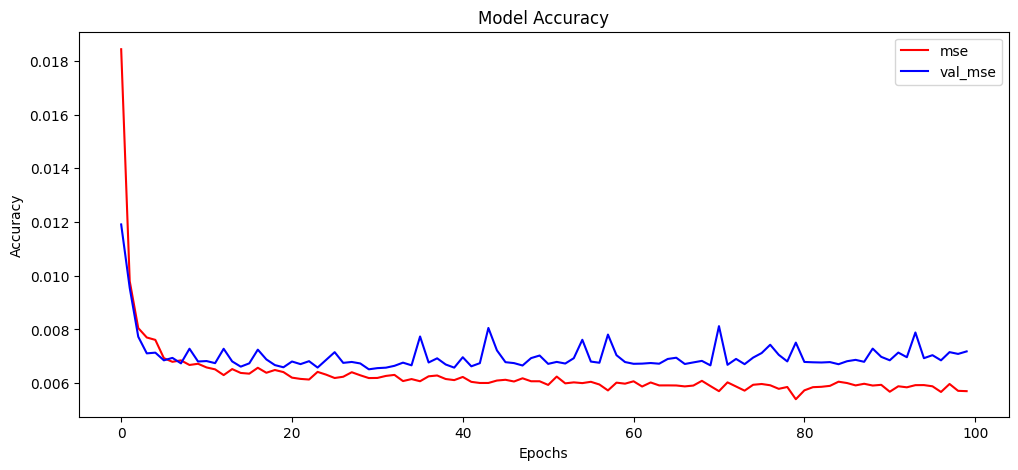

In [17]:
plt.figure(figsize=(12, 5))
plt.plot(history.history['mse'], color='r')
plt.plot(history.history['val_mse'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['mse', 'val_mse'])
plt.show()

In [18]:
a=fis.model.summary()


Model: "myanfis"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ inputLayer          │ (1, 6)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fuzzyLayer          │ (1, 3, 6)         │         36 │ inputLayer[0][0]  │
│ (FuzzyLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ruleLayer           │ (1, 729)          │          0 │ fuzzyLayer[0][0]  │
│ (RuleLayer)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normLayer           │ (1, 729)          │          0 │ ruleLayer[0][0]   │
│ (NormLayer)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ defuzzLayer         │ (1, 729)          │      5,103 │ normLayer[0][0],  │
│ (DefuzzLayer)       │                   │            │ inputLayer[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sumLayer            │ (1, 1)            │          0 │ defuzzLayer[0][0] │
│ (SummationLayer)    │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 15,419 (60.23 KB)

 Trainable params: 5,139 (20.07 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,280 (40.16 KB)

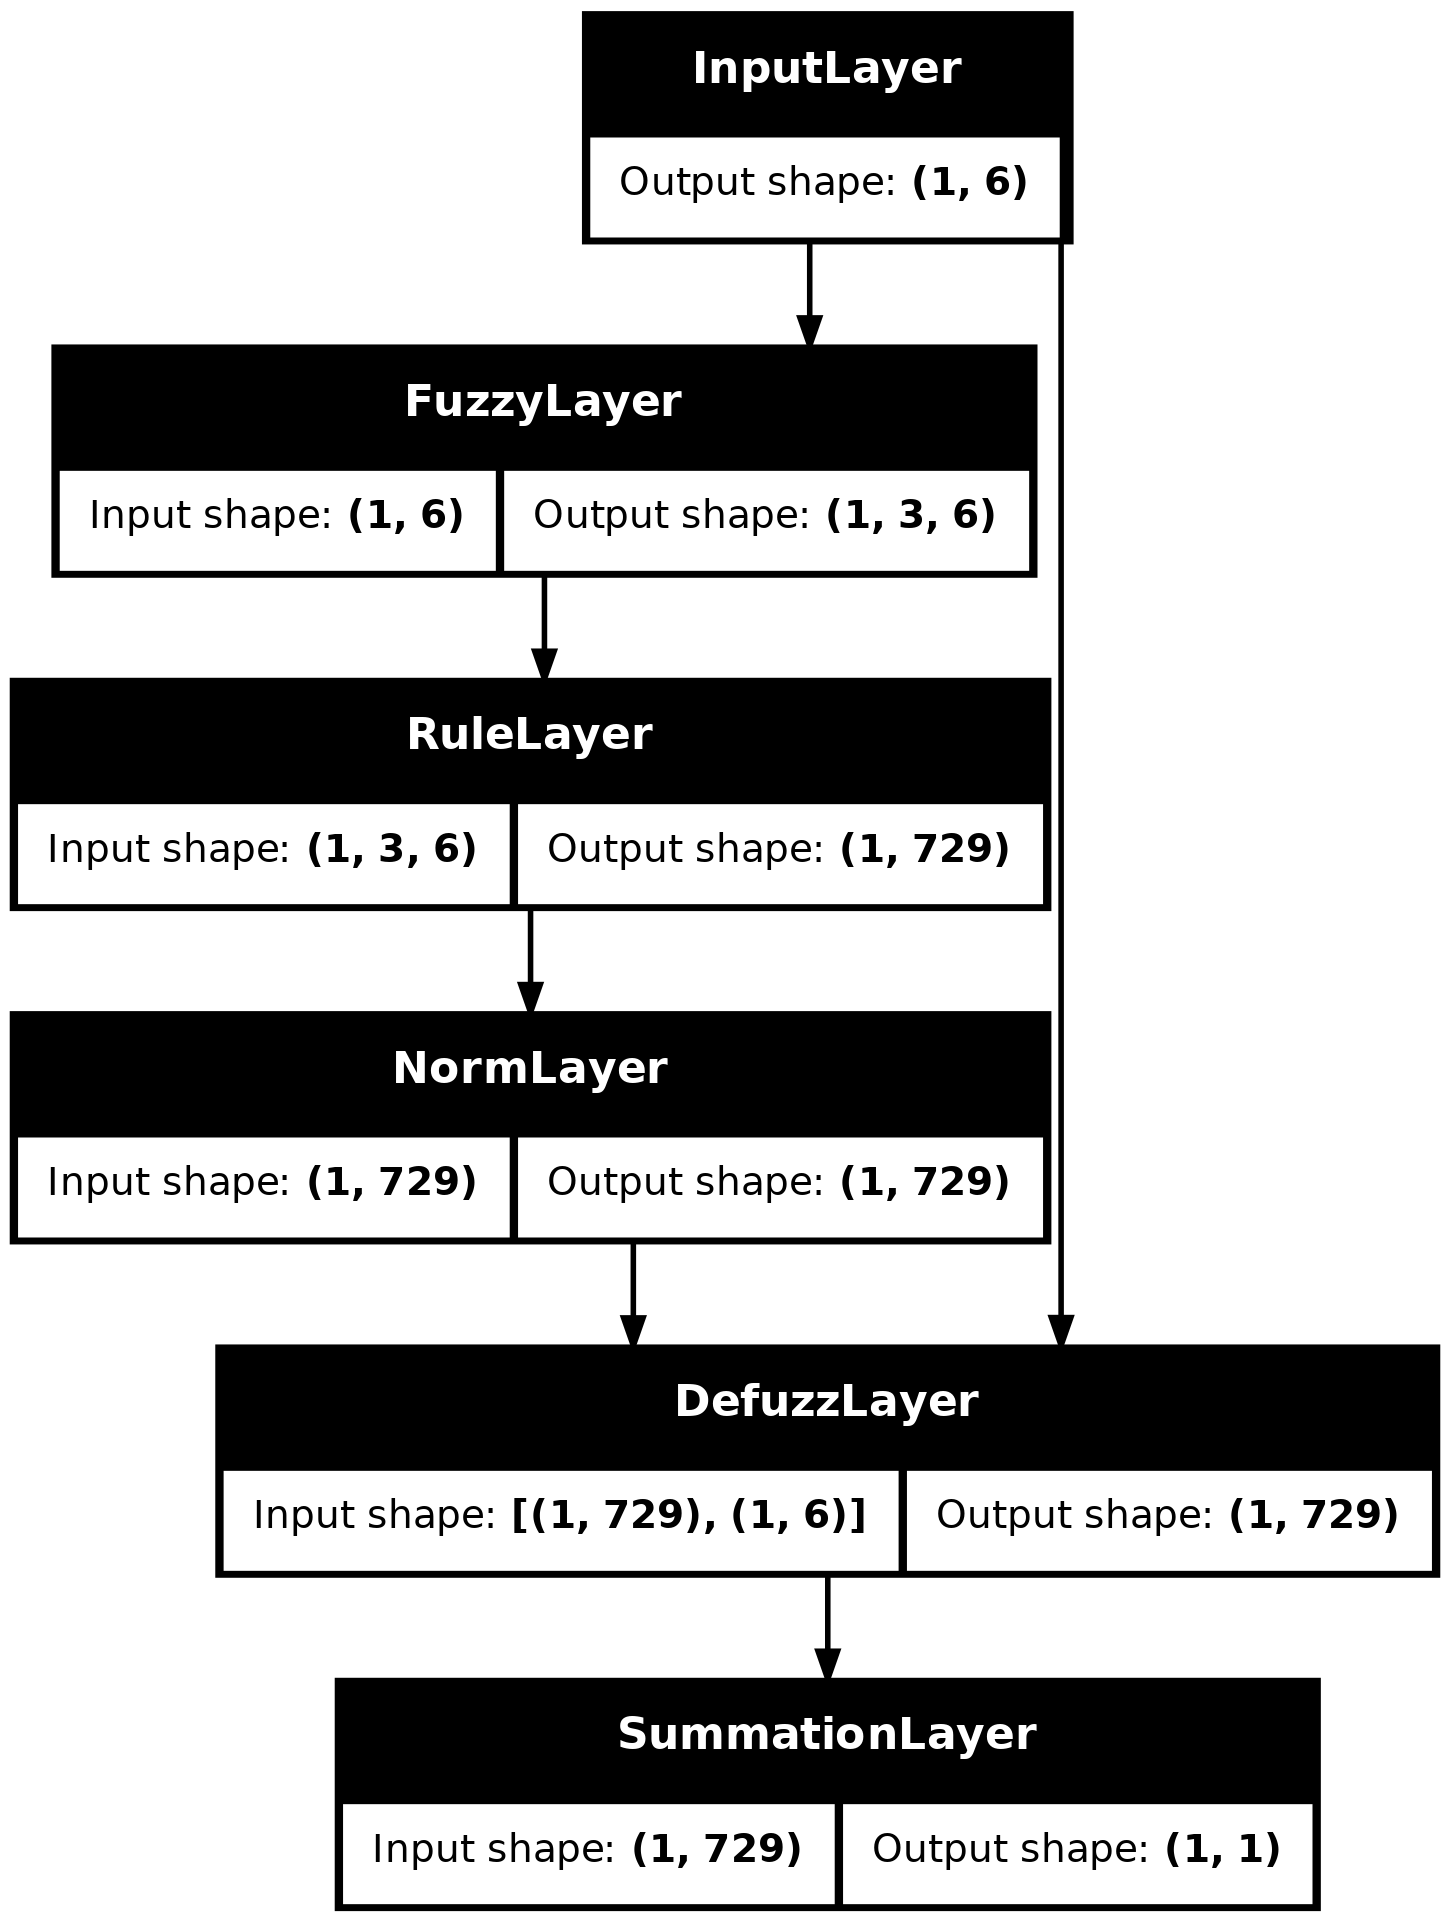

In [19]:
from keras.utils import plot_model


plot_model(fis.model, to_file='multiple_outputs.png',show_shapes=True)

In [20]:
print(X_test.shape)
#y_test=y_test.reshape(42,1)
y_test.shape

#pred= fis.model.predict(X_test)

(102, 6)


(102,)

In [21]:

y_pred = fis(X_test)

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step


102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step


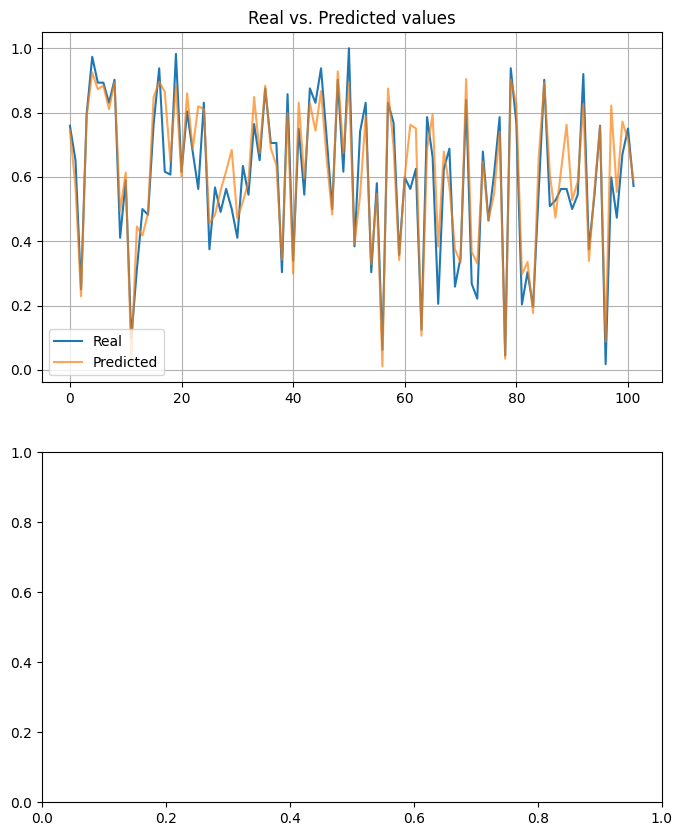

In [22]:
# ## Evaluate Model
# fis.model.evaluate(X_test, y_test)
plot_prediction=True
if plot_prediction:
    y_pred = fis(X_test)
    f, axs = plt.subplots(2, 1, figsize=(8, 10))
    # f.suptitle(f'{gen.get_data_name(data_id)} time series', size=16)
    axs[0].plot(y_test)
    axs[0].plot(y_pred, alpha=.7)
    axs[0].legend(['Real', 'Predicted'])
    axs[0].grid(True)
    axs[0].set_title('Real vs. Predicted values')
    # axs[1].plot(y_test, y_test - y_pred)
    # axs[1].legend(['pred_error'])
    # axs[1].grid(True)
    # axs[1].set_title('Prediction Error')
    plt.show()

In [23]:
y_test=y_test.reshape(102,1)
co=np.concatenate((y_test, y_pred),axis=1)

In [24]:
column_values= ['Real', 'Prediction']
df = pd.DataFrame(data = co,columns = column_values)
df.reset_index(inplace = True)

r2 Score : 0.8690782123503176
MSE Score : 0.007182626012809569
MAE Score : 0.06458214664522145


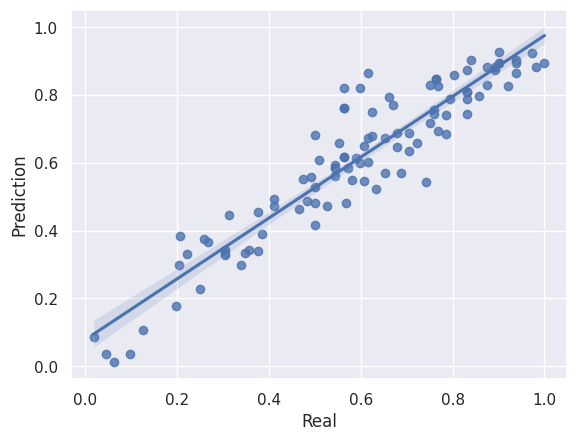

In [25]:
import seaborn as sns

from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
print("r2 Score :",r2_score(y_test, y_pred))
print("MSE Score :",mean_squared_error(y_test, y_pred))
print("MAE Score :",mean_absolute_error(y_test, y_pred))

sns.set_theme(color_codes=True)
ax = sns.regplot(x="Real", y="Prediction", data=df)